In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, RMSprop
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import numpy as np
import pandas as pd

from datasets import load_dataset

#데이터셋 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
dataset = load_dataset('imdb')
train_data = dataset['train']  # 25,000개

# DataFrame으로 변환
Train = pd.DataFrame({
    'Text': train_data['text'],
    'Sentiment': train_data['label']
})

Train = Train.dropna()
'''

"\ndataset = load_dataset('imdb')\ntrain_data = dataset['train']  # 25,000개\n\n# DataFrame으로 변환\nTrain = pd.DataFrame({\n    'Text': train_data['text'],\n    'Sentiment': train_data['label']\n})\n\nTrain = Train.dropna()\n"

In [ ]:
#Train = Train[['Sentiment', 'Text']]

In [ ]:
#df_train = pd.read_csv("/content/drive/MyDrive/[URP] - DLI LAB/train_paired.tsv", sep='\t')
#df_val = pd.read_csv("/content/drive/MyDrive/[URP] - DLI LAB/dev_paired.tsv", sep='\t')
#df_test = pd.read_csv("/content/drive/MyDrive/[URP] - DLI LAB/test_paired.tsv", sep='\t')
Train = pd.read_csv("/content/drive/MyDrive/[URP] - DLI LAB/train.tsv", sep='\t')

Test = pd.read_csv("/content/drive/MyDrive/[URP] - DLI LAB/test_new.tsv", sep='\t')
Val = pd.read_csv("/content/drive/MyDrive/[URP] - DLI LAB/dev_new.tsv", sep='\t')

In [ ]:
'''
data_li = [df_train, df_val, df_test]

for i in data_li:
    i.drop('batch_id', axis=1, inplace=True)
'''

"\ndata_li = [df_train, df_val, df_test]\n\nfor i in data_li:\n    i.drop('batch_id', axis=1, inplace=True)\n"

In [ ]:
def preprocess(df):
    df['Sentiment'] = df['Sentiment'].map({'Negative': 0, 'Positive': 1})
    return df

#df_train = preprocess(df_train)
#df_val = preprocess(df_val)
#df_test = preprocess(df_test)
Train = preprocess(Train)
Test = preprocess(Test)
Val = preprocess(Val)

#RoBERTa - base 모델 로드

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#모델 훈련 - SAM

In [ ]:
class SAM(torch.optim.Optimizer):
    """SAM optimizer - base implementation"""
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale
                p.data.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                if "e_w" in self.state[p]:
                    p.data.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2).to(shared_device)
                for group in self.param_groups for p in group["params"]
                if p.grad is not None
            ]),
            p=2
        )
        return norm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# 1. 커스텀 데이터셋 클래스
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['Text'])  # 텍스트 컬럼명에 맞게 수정
        label = row['Sentiment']     # Sentiment 컬럼 사용

        # 토크나이징
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 2. 분류 모델 정의
class RobertaClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.1):
        super(RobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)  # RoBERTa-base hidden size: 768

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # [CLS] 토큰의 representation 사용
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.classifier(output)
        return logits

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        # 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # SAM First Step
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        # SAM Second Step
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.second_step(zero_grad=True)

        total_loss += loss.item()

        # 예측값 저장
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1

In [ ]:
# 4. 검증 함수
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1

In [ ]:
# 5. 메인 학습 코드
def main(df_train, df_val, df_test):
    # 하이퍼파라미터 설정
    MAX_LENGTH = 256
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    MOMENTUM = 0.9         # SGD with momentum
    WEIGHT_DECAY = 0.01    # L2 정규화
    NUM_EPOCHS = 10
    NUM_CLASSES = df_train['Sentiment'].nunique()  # 클래스 수 자동 계산

    # 토크나이저 및 모델 초기화
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaClassifier(num_classes=NUM_CLASSES)
    model = model.to(device)

    # 데이터셋 생성
    train_dataset = TextDataset(df_train, tokenizer, MAX_LENGTH)
    val_dataset = TextDataset(df_val, tokenizer, MAX_LENGTH)
    test_dataset = TextDataset(df_test, tokenizer, MAX_LENGTH)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    ##### SAM 옵티마이저 설정 ######
    base_optimizer = SGD  # Adam을 base optimizer로 사용
    optimizer = SAM(
        model.parameters(),
        base_optimizer=base_optimizer,
        rho=0.05,  # SAM의 perturbation 크기
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    # 학습률 스케줄러 (선택사항)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer.base_optimizer,  # SAM의 base_optimizer에 스케줄러 적용
        T_max=NUM_EPOCHS,
        eta_min=1e-6
    )

    # 손실 함수
    criterion = nn.CrossEntropyLoss()

    # 학습 시작
    best_val_accuracy = 0
    train_losses, val_losses = [], []

    for epoch in range(NUM_EPOCHS):
        print(f'\n========== Epoch {epoch+1}/{NUM_EPOCHS} ==========')

        # 학습
        train_loss, train_acc, train_f1 = train_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # 검증
        val_loss, val_acc, val_f1 = validate(
            model, val_loader, criterion, device
        )

        # 학습률 업데이트
        scheduler.step()

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # 최고 성능 모델 저장
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
            }, 'best_roberta_model.pt')
            print(f'✓ Best model saved with validation accuracy: {val_acc:.4f}')

    # 테스트 평가
    print('\n========== Test Evaluation ==========')
    # 최고 성능 모델 로드
    checkpoint = torch.load('best_roberta_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_acc, test_f1 = validate(
        model, test_loader, criterion, device
    )
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}')

    return model, train_losses, val_losses

In [ ]:
# 6. 추가 유틸리티 함수들

def predict(model, text, tokenizer, device, max_length=256):
    """단일 텍스트 예측"""
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        pred = torch.argmax(logits, dim=1)

    return pred.item()

def predict_batch(model, texts, tokenizer, device, max_length=256):
    """배치 텍스트 예측"""
    model.eval()
    predictions = []

    for text in texts:
        pred = predict(model, text, tokenizer, device, max_length)
        predictions.append(pred)

    return predictions

=== 데이터 확인 ===
Train shape: (1707, 2)
Columns: ['Sentiment', 'Text']
Sentiment values: [0 1]
Class distribution:
Sentiment
1    856
0    851
Name: count, dtype: int64



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



========== Epoch 1/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.20it/s]


Train Loss: 0.7781 | Train Acc: 0.4095 | Train F1: 0.4071
Val Loss: 0.6927 | Val Acc: 0.5020 | Val F1: 0.3356
Learning Rate: 0.000020
✓ Best model saved with validation accuracy: 0.5020

========== Epoch 2/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.02it/s]


Train Loss: 0.7224 | Train Acc: 0.4839 | Train F1: 0.4839
Val Loss: 0.4314 | Val Acc: 0.9102 | Val F1: 0.9100
Learning Rate: 0.000018
✓ Best model saved with validation accuracy: 0.9102

========== Epoch 3/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.05it/s]


Train Loss: 0.4801 | Train Acc: 0.8137 | Train F1: 0.8135
Val Loss: 0.3285 | Val Acc: 0.8612 | Val F1: 0.8593
Learning Rate: 0.000016

========== Epoch 4/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.05it/s]


Train Loss: 0.3497 | Train Acc: 0.8764 | Train F1: 0.8764
Val Loss: 0.2004 | Val Acc: 0.9429 | Val F1: 0.9428
Learning Rate: 0.000013
✓ Best model saved with validation accuracy: 0.9429

========== Epoch 5/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.02it/s]


Train Loss: 0.2835 | Train Acc: 0.9110 | Train F1: 0.9110
Val Loss: 0.1958 | Val Acc: 0.9429 | Val F1: 0.9428
Learning Rate: 0.000011

========== Epoch 6/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.90it/s]


Train Loss: 0.2452 | Train Acc: 0.9262 | Train F1: 0.9262
Val Loss: 0.2184 | Val Acc: 0.9429 | Val F1: 0.9428
Learning Rate: 0.000008

========== Epoch 7/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.04it/s]


Train Loss: 0.2004 | Train Acc: 0.9397 | Train F1: 0.9397
Val Loss: 0.1811 | Val Acc: 0.9551 | Val F1: 0.9551
Learning Rate: 0.000005
✓ Best model saved with validation accuracy: 0.9551

========== Epoch 8/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.18it/s]


Train Loss: 0.1836 | Train Acc: 0.9484 | Train F1: 0.9484
Val Loss: 0.1895 | Val Acc: 0.9510 | Val F1: 0.9510
Learning Rate: 0.000003

========== Epoch 9/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.15it/s]


Train Loss: 0.1733 | Train Acc: 0.9531 | Train F1: 0.9531
Val Loss: 0.1795 | Val Acc: 0.9592 | Val F1: 0.9592
Learning Rate: 0.000001
✓ Best model saved with validation accuracy: 0.9592

========== Epoch 10/10 ==========


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.14it/s]


Train Loss: 0.1579 | Train Acc: 0.9572 | Train F1: 0.9572
Val Loss: 0.2104 | Val Acc: 0.9388 | Val F1: 0.9387
Learning Rate: 0.000001

========== Test Evaluation ==========


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.12it/s]


Test Loss: 0.1339 | Test Acc: 0.9549 | Test F1: 0.9549


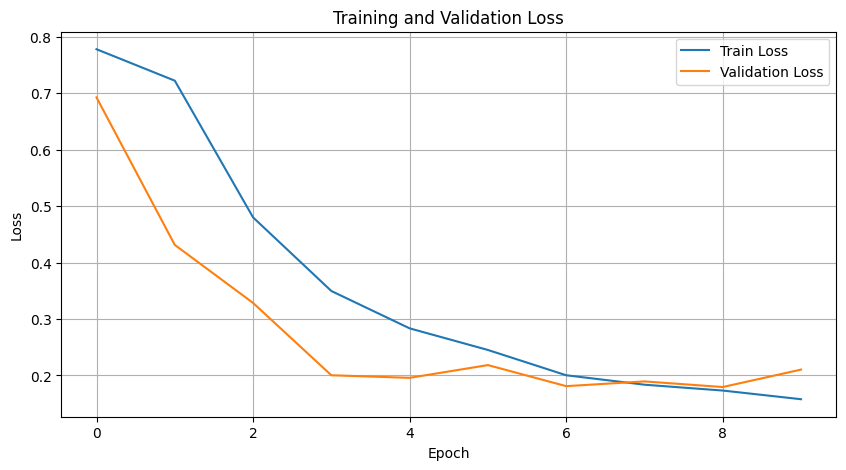

Prediction for 'This is a sample text for prediction': 1


In [ ]:
# 7. 실행 예시 - O Test
if __name__ == "__main__":
    # 데이터프레임이 다음과 같은 형식이라고 가정:
    # Train, Val, Test 'text'와 'Sentiment' 컬럼을 가져야 함

    # 데이터 확인 (선택사항)
    print("=== 데이터 확인 ===")
    print(f"Train shape: {Train.shape}")
    print(f"Columns: {Train.columns.tolist()}")
    print(f"Sentiment values: {Train['Sentiment'].unique()}")
    print(f"Class distribution:\n{Train['Sentiment'].value_counts()}\n")

    # 모델 학습
    model, train_losses, val_losses = main(Train, Val, Test)

    # 학습 곡선 시각화 (선택사항)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 예측 예시
    sample_text = "This is a sample text for prediction"
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    prediction = predict(model, sample_text, tokenizer, device)
    print(f"Prediction for '{sample_text}': {prediction}")